In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Callable
import re
import orjson as json
from collections import defaultdict
import os
import my_utils

In [2]:
DPI=300

In [3]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
current_dir = os.path.dirname(".")
testcase = "throughput" # "throughput" or "goodput"
plots_directory = os.path.join(current_dir, "plots")

## Perf

In [14]:
uncategorized = defaultdict(int)
def mcmpquic_extract_nb_paths(filepath: str) -> int:
    """ Extract path information from the logs of a mcMPQUIC endpoint. Idealy from the server as it is the one
    that validates a path lastly. [MPQUIC detail]
    """
    pattern = re.compile(r".*(p|P)ath.*is now validated")
    nb_paths = 0
    with open(filepath) as f:
        for line in f: 
            if pattern.match(line):
                nb_paths += 1
    return nb_paths + 1 # +1 for the default path

def map_entry_to_symbol(symbols: List[str], mapping: dict) -> str:
    for symbol in symbols:
        for mpng, mpng_cat in mapping.items():
            if re.match(mpng[6:], symbol, re.IGNORECASE):
                return mpng_cat
    return None

def parse(perf_record_file, mapping_file, process_name) -> dict:
    with open(mapping_file) as f:
        mapping = json.loads(f.read())
    with open(perf_record_file) as f:
        data = f.read()
    data = data.split("\n\n")
    classification = defaultdict(int)
    all_recorded_samples = 0
    uncategorized_samples_cpu_cycles = 0
    for callchain in data:
        callchain = callchain.split("\n")
        splitted_header = callchain[0].split()
        if len(splitted_header) != 5:
            continue
        cycles = int(splitted_header[-2])
        all_recorded_samples += cycles
        symbols = [entry.split()[1] for entry in callchain[1:]]
        category = map_entry_to_symbol(symbols, mapping)
        if category is None:
            uncategorized_samples_cpu_cycles += cycles
        else:
            classification[category] += cycles
    classification["UNCATEGORIZED"] = uncategorized_samples_cpu_cycles
    for key, value in classification.items():
        classification[key] = value / all_recorded_samples * 100
    return classification

def extract_perf_data_from_file(perf_record_file, mapping_file, process_name: str) -> pd.DataFrame:
    """ Return a dataframe
        category | cpu_cycles 
    """
    data = parse(perf_record_file, mapping_file, process_name)
    new_data = defaultdict(int) 
    total = 0
    for key, value in data.items():
        retained = key.split(" ")[0]
        new_data[retained] += value
        total += value
    df = pd.DataFrame(new_data.items(), columns=["category", "cpu_cycles"])
    return df

def extract_perf_data_per_role(role_logs: str, mapping_json_file: str, process_name: str):
    """ Returns a dataframe:
        category | cpu_cycles [%]
    """
    perf_record_file = [f for f in os.listdir(role_logs) if f.endswith("perf_record.txt")]
    if len(perf_record_file) == 0:
        return pd.DataFrame(columns=["category", "cpu_cycles"])
    elif len(perf_record_file) > 1:
        raise Exception("Multiple perf.json files found")
    return extract_perf_data_from_file(os.path.join(role_logs, perf_record_file[0]), mapping_json_file, process_name)

def extract_perf_data_per_run(run_logs: str, extract_nb_paths: Callable[[str], int], mapping: str, impl_name: str) -> pd.DataFrame:
    """ Returns a dataframe:
        category | cpu_cycles | role | nb_cores
    """
    if extract_nb_paths is None:
        raise Exception("No perf.json file found")
    df = pd.DataFrame(columns=["category", "cpu_cycles", "role", "nb_cores"])
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    df_client = extract_perf_data_per_role(os.path.join(run_logs, "client"), mapping, impl_name+"-client")
    df_client["role"] = "client"
    df_client["nb_cores"] = nb_paths
    df = pd.concat([df, df_client], ignore_index=True)
    df_server = extract_perf_data_per_role(os.path.join(run_logs, "server"), mapping, impl_name+"-server")
    df_server["role"] = "server"
    df_server["nb_cores"] = nb_paths
    df = pd.concat([df, df_server], ignore_index=True)
    return df

def extract_perf_data_per_testcase(testcase_logs: str, extract_nb_paths: Callable[[str], int], mapping: str, impl_name: str) -> pd.DataFrame:
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["category", "cpu_cycles", "role", "nb_cores"])
    for run_dir in runs_dirs:
        run_logs = os.path.join(testcase_logs, run_dir)
        df_run = extract_perf_data_per_run(run_logs, extract_nb_paths, mapping, impl_name)
        df = pd.concat([df, df_run], ignore_index=True)
    avg_df = df.groupby(["category", "role", "nb_cores"]).mean().reset_index()
    return avg_df

def extract_perf_data_per_testcase_impl(implementation_logs: str, impl_name: str, extract_nb_paths: Callable[[str], int], mapping: str) -> pd.DataFrame:
    """ Returns a dataframe:
        category | cpu_cycles | role | nb_cores | implementation
    """
    df = extract_perf_data_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths, mapping, impl_name)
    df["implementation"] = impl_name
    return df

def extract_perf_data_from_logs(logs: List[str], mapping: str) -> pd.DataFrame:
    """ Returns a dataframe:
        category | cpu_cycles | role | nb_cores | implementation 
    """
    df = pd.DataFrame(columns=["category", "cpu_cycles", "role", "nb_cores", "implementation"])
    for logs_dir in logs:
        logs_dir = os.path.join(logs_directory, logs_dir)
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name in ["mcmpquic", "mpquic"]:
                df_ret = extract_perf_data_per_testcase_impl(os.path.join(logs_dir, implemantation_logs), impl_name, mcmpquic_extract_nb_paths, mapping)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception("Unknown implementation" + impl_name)
    return df


In [15]:
df_client = extract_perf_data_from_logs(["logs_2024-05-24T20:48:14"], "./mcmpquic-mapping.json")
df_server = extract_perf_data_from_logs(["logs_2024-05-25T04:20:45", "logs_2024-05-25T13:26:46"], "./mcmpquic-mapping.json")
df = pd.concat([df_client, df_server], ignore_index=True)

In [16]:
def axe_plot_profiling_per_core(ax: plt.Axes, df: pd.DataFrame, title: str):
    import numpy as np
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors = [ my_utils.get_color_for_impl(impl) for impl in implementations]
    next_index = 0
    x = np.arange(len(df["category"].unique()))
    width = 0.3
    categories = sorted(list(df["category"].unique()))
    for implementation in implementations:
        cycles = []
        for category in categories:
            if category in df.loc[df["implementation"] == implementation]["category"].values:
                cycles.append(df.loc[(df["implementation"] == implementation) & (df["category"] == category)]["cpu_cycles"].values[0])
            else:
                cycles.append(0)
        offset = 0.3 * next_index
        ax.bar(x + offset, cycles, color=colors[next_index], label=implementation, zorder=2, width=width)
        next_index += 1
    
        
    ax.grid(which='major',axis='y',  color='black', linewidth=1, alpha=0.3, linestyle="dashed")
    ax.grid(which='minor',axis='y',  color='black', linewidth=1, alpha=0.3, linestyle="dashed")
    ax.legend()
    ax.set_ylabel("CPU Cycles [%]")
    ax.set_title(title)
    ax.set_xticks(x + 0.3 * (next_index - 1) / 2)
    ax.set_xticklabels(categories, rotation=70, ha="right")  
    
def plot_profiling_per_core(df: pd.DataFrame, title: str):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=DPI, sharey=True)
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.1)
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    axe_plot_profiling_per_core(axes[0], client_df, "Client")
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    axe_plot_profiling_per_core(axes[1], server_df, "Server")

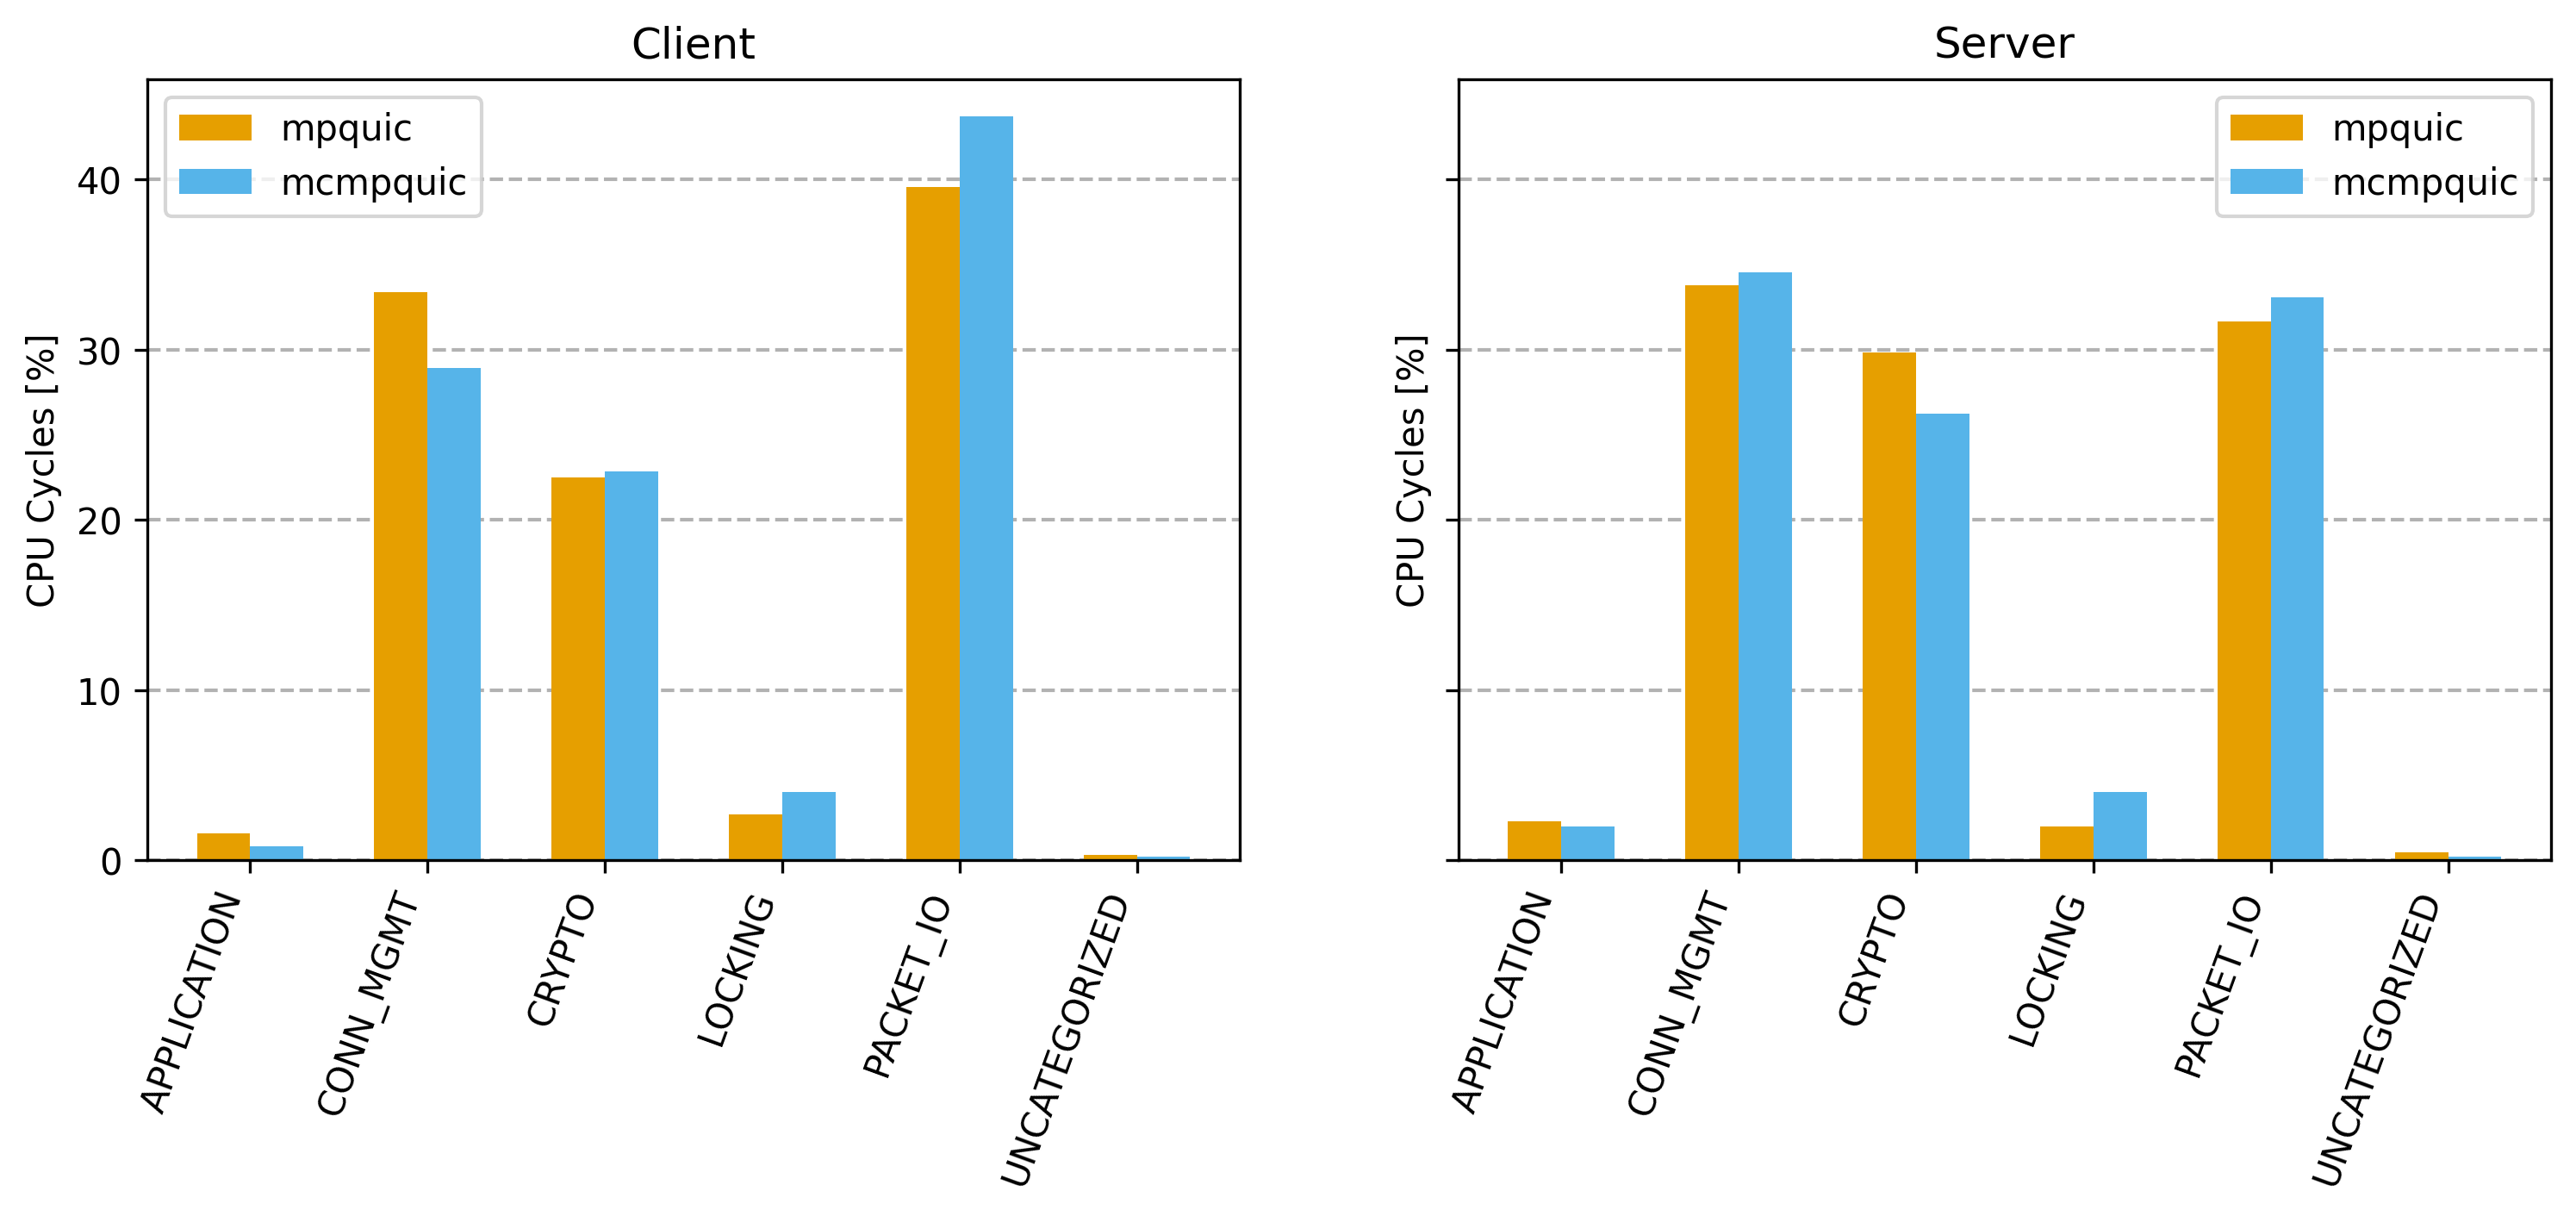

In [17]:
nb_paths = 1
custom_df = df.loc[df["nb_cores"] == nb_paths]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_profiling_per_core(custom_df, "")
plt.savefig(os.path.join(plots_directory, f"profiling_per_core_nb_paths_{nb_paths}.pdf"), bbox_inches='tight', dpi=DPI, format="pdf")

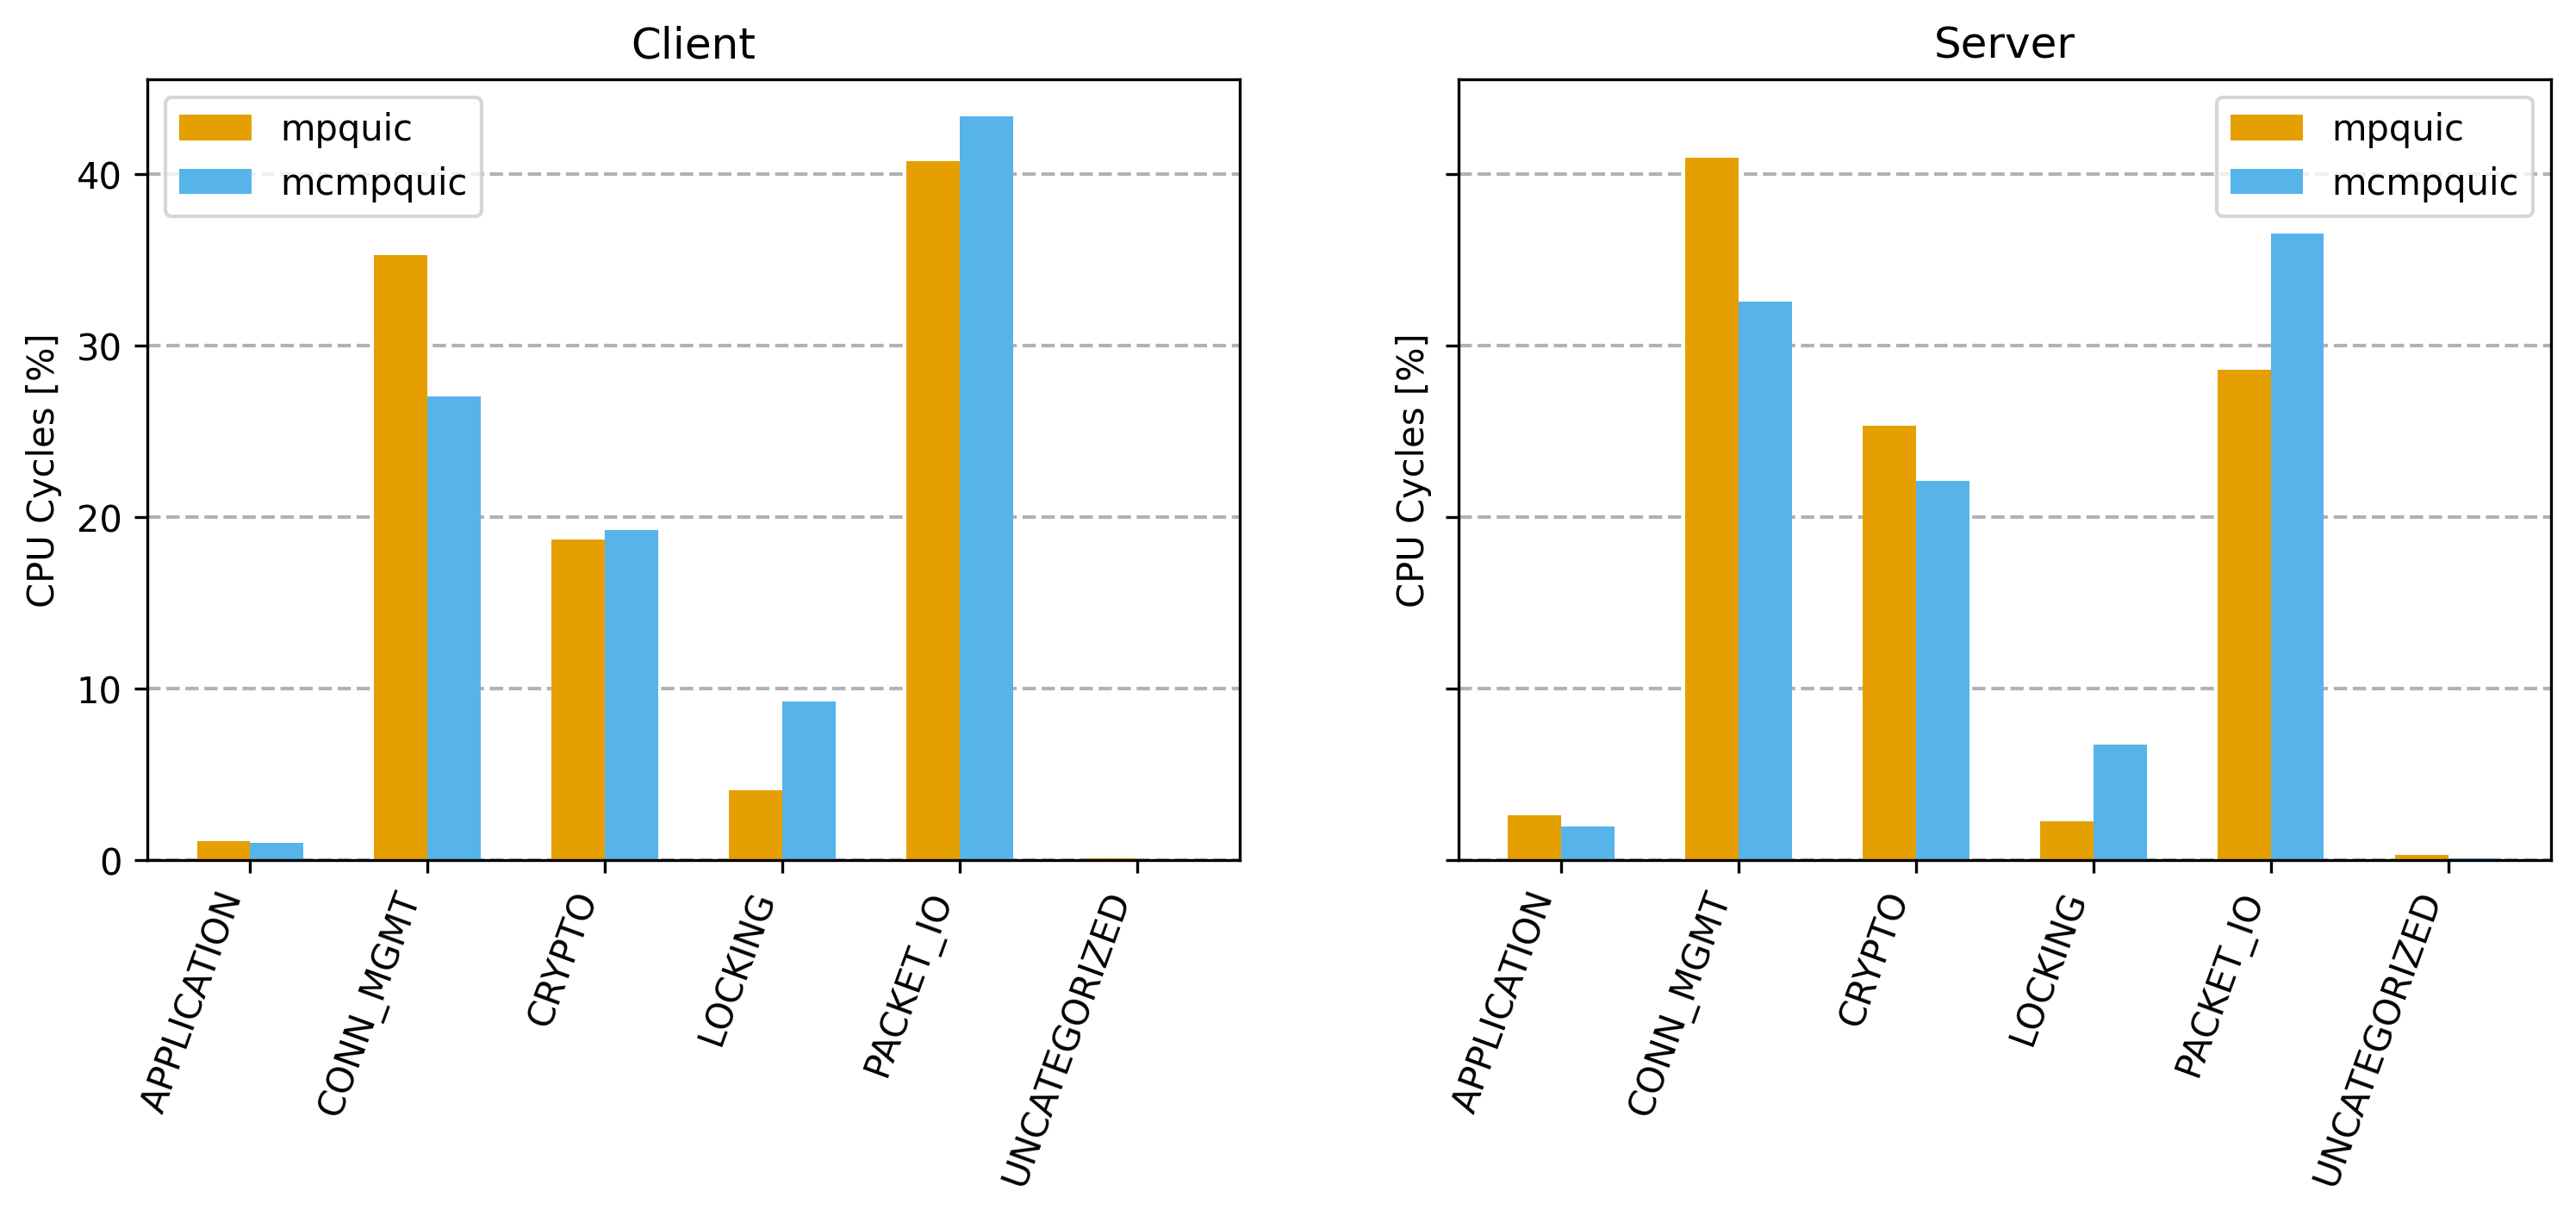

In [18]:
nb_paths = 4
custom_df = df.loc[df["nb_cores"] == nb_paths]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_profiling_per_core(custom_df, "")
plt.savefig(os.path.join(plots_directory, f"profiling_per_core_nb_paths_{nb_paths}.pdf"), bbox_inches='tight', dpi=DPI, format="pdf")

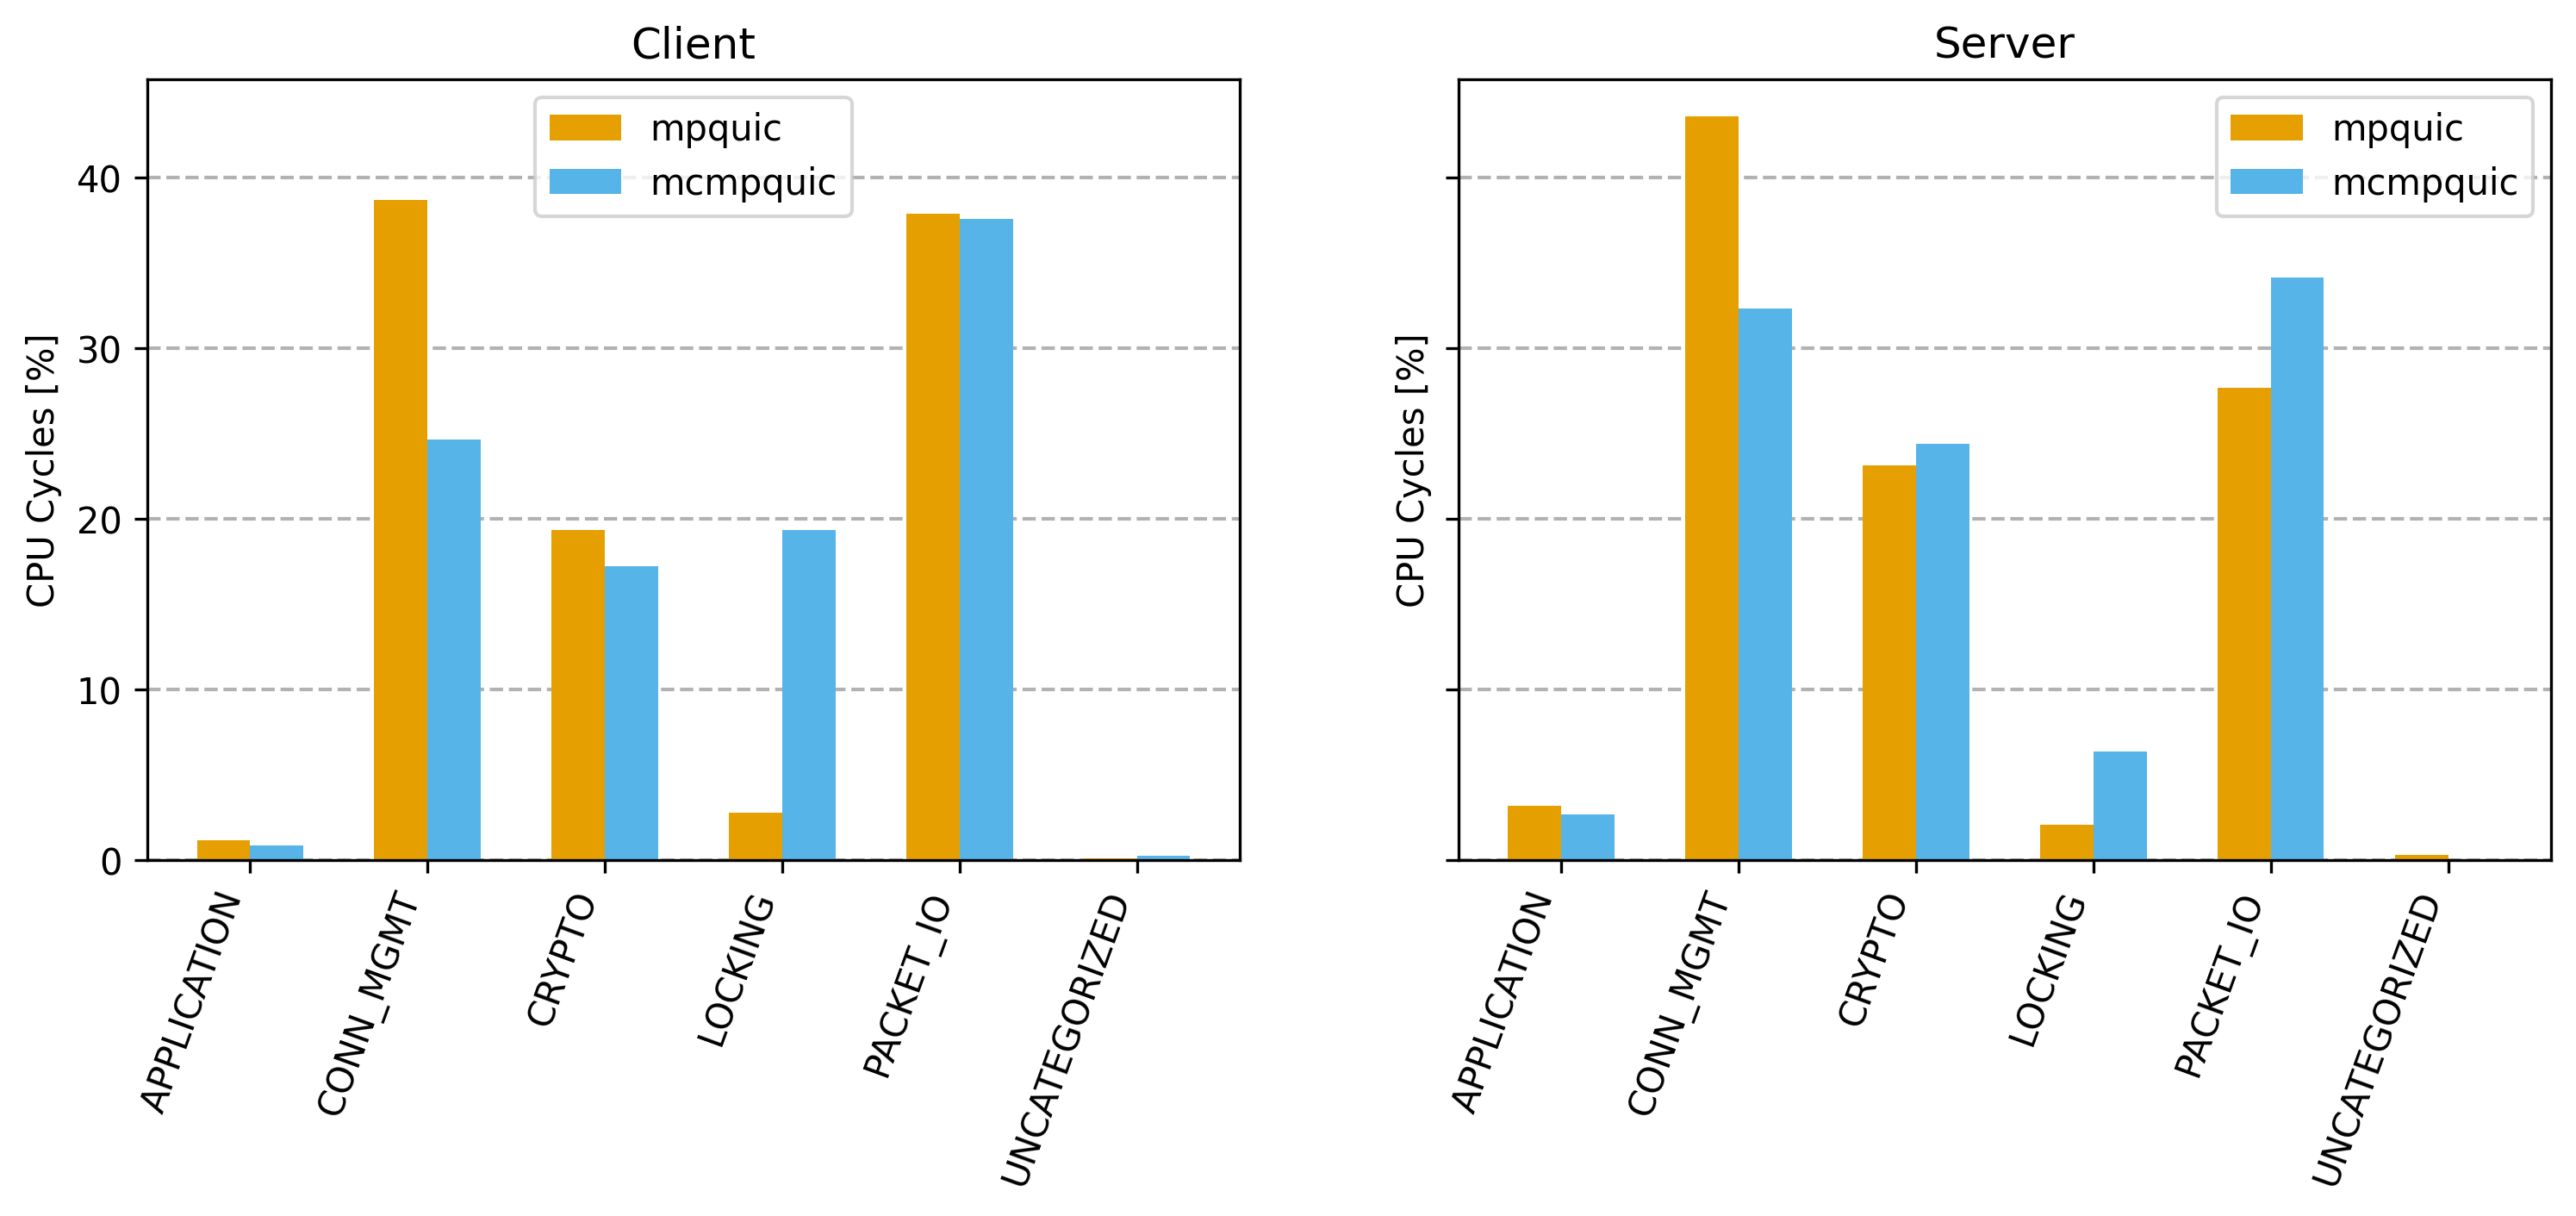

In [19]:
nb_paths = 8
custom_df = df.loc[df["nb_cores"] == nb_paths]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_profiling_per_core(custom_df, "")
plt.savefig(os.path.join(plots_directory, f"profiling_per_core_nb_paths_{nb_paths}.pdf"), bbox_inches='tight', dpi=DPI, format="pdf")

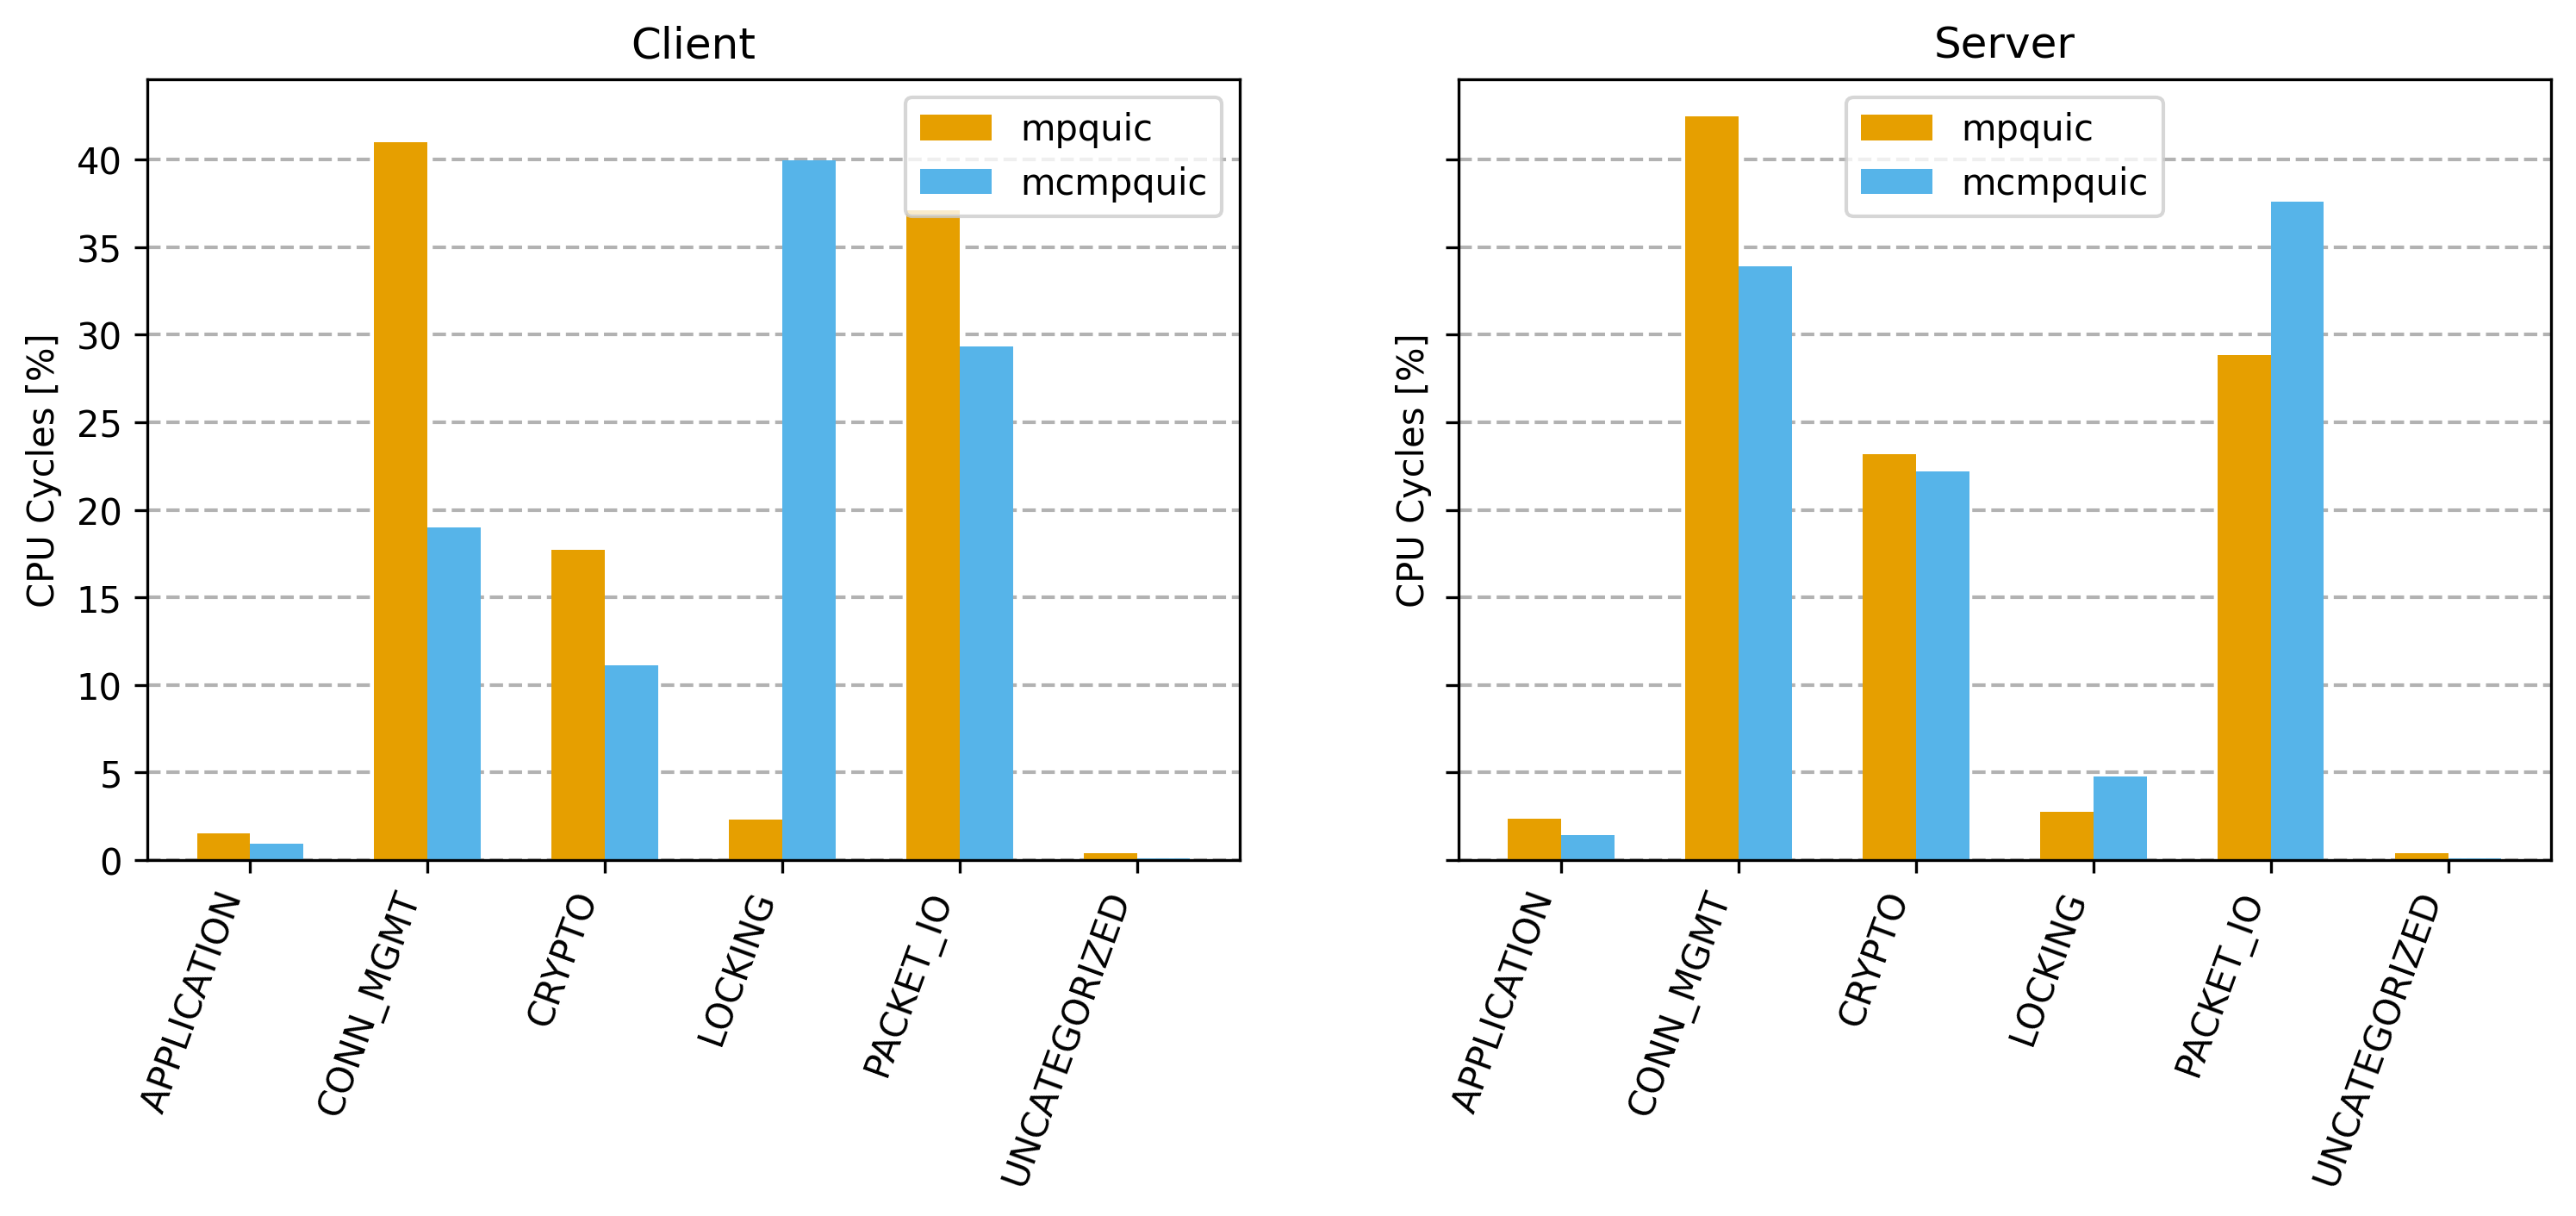

In [20]:
nb_paths = 12
custom_df = df.loc[df["nb_cores"] == nb_paths]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_profiling_per_core(custom_df, "")
plt.savefig(os.path.join(plots_directory, f"profiling_per_core_nb_paths_{nb_paths}.pdf"), bbox_inches='tight', dpi=DPI, format="pdf")

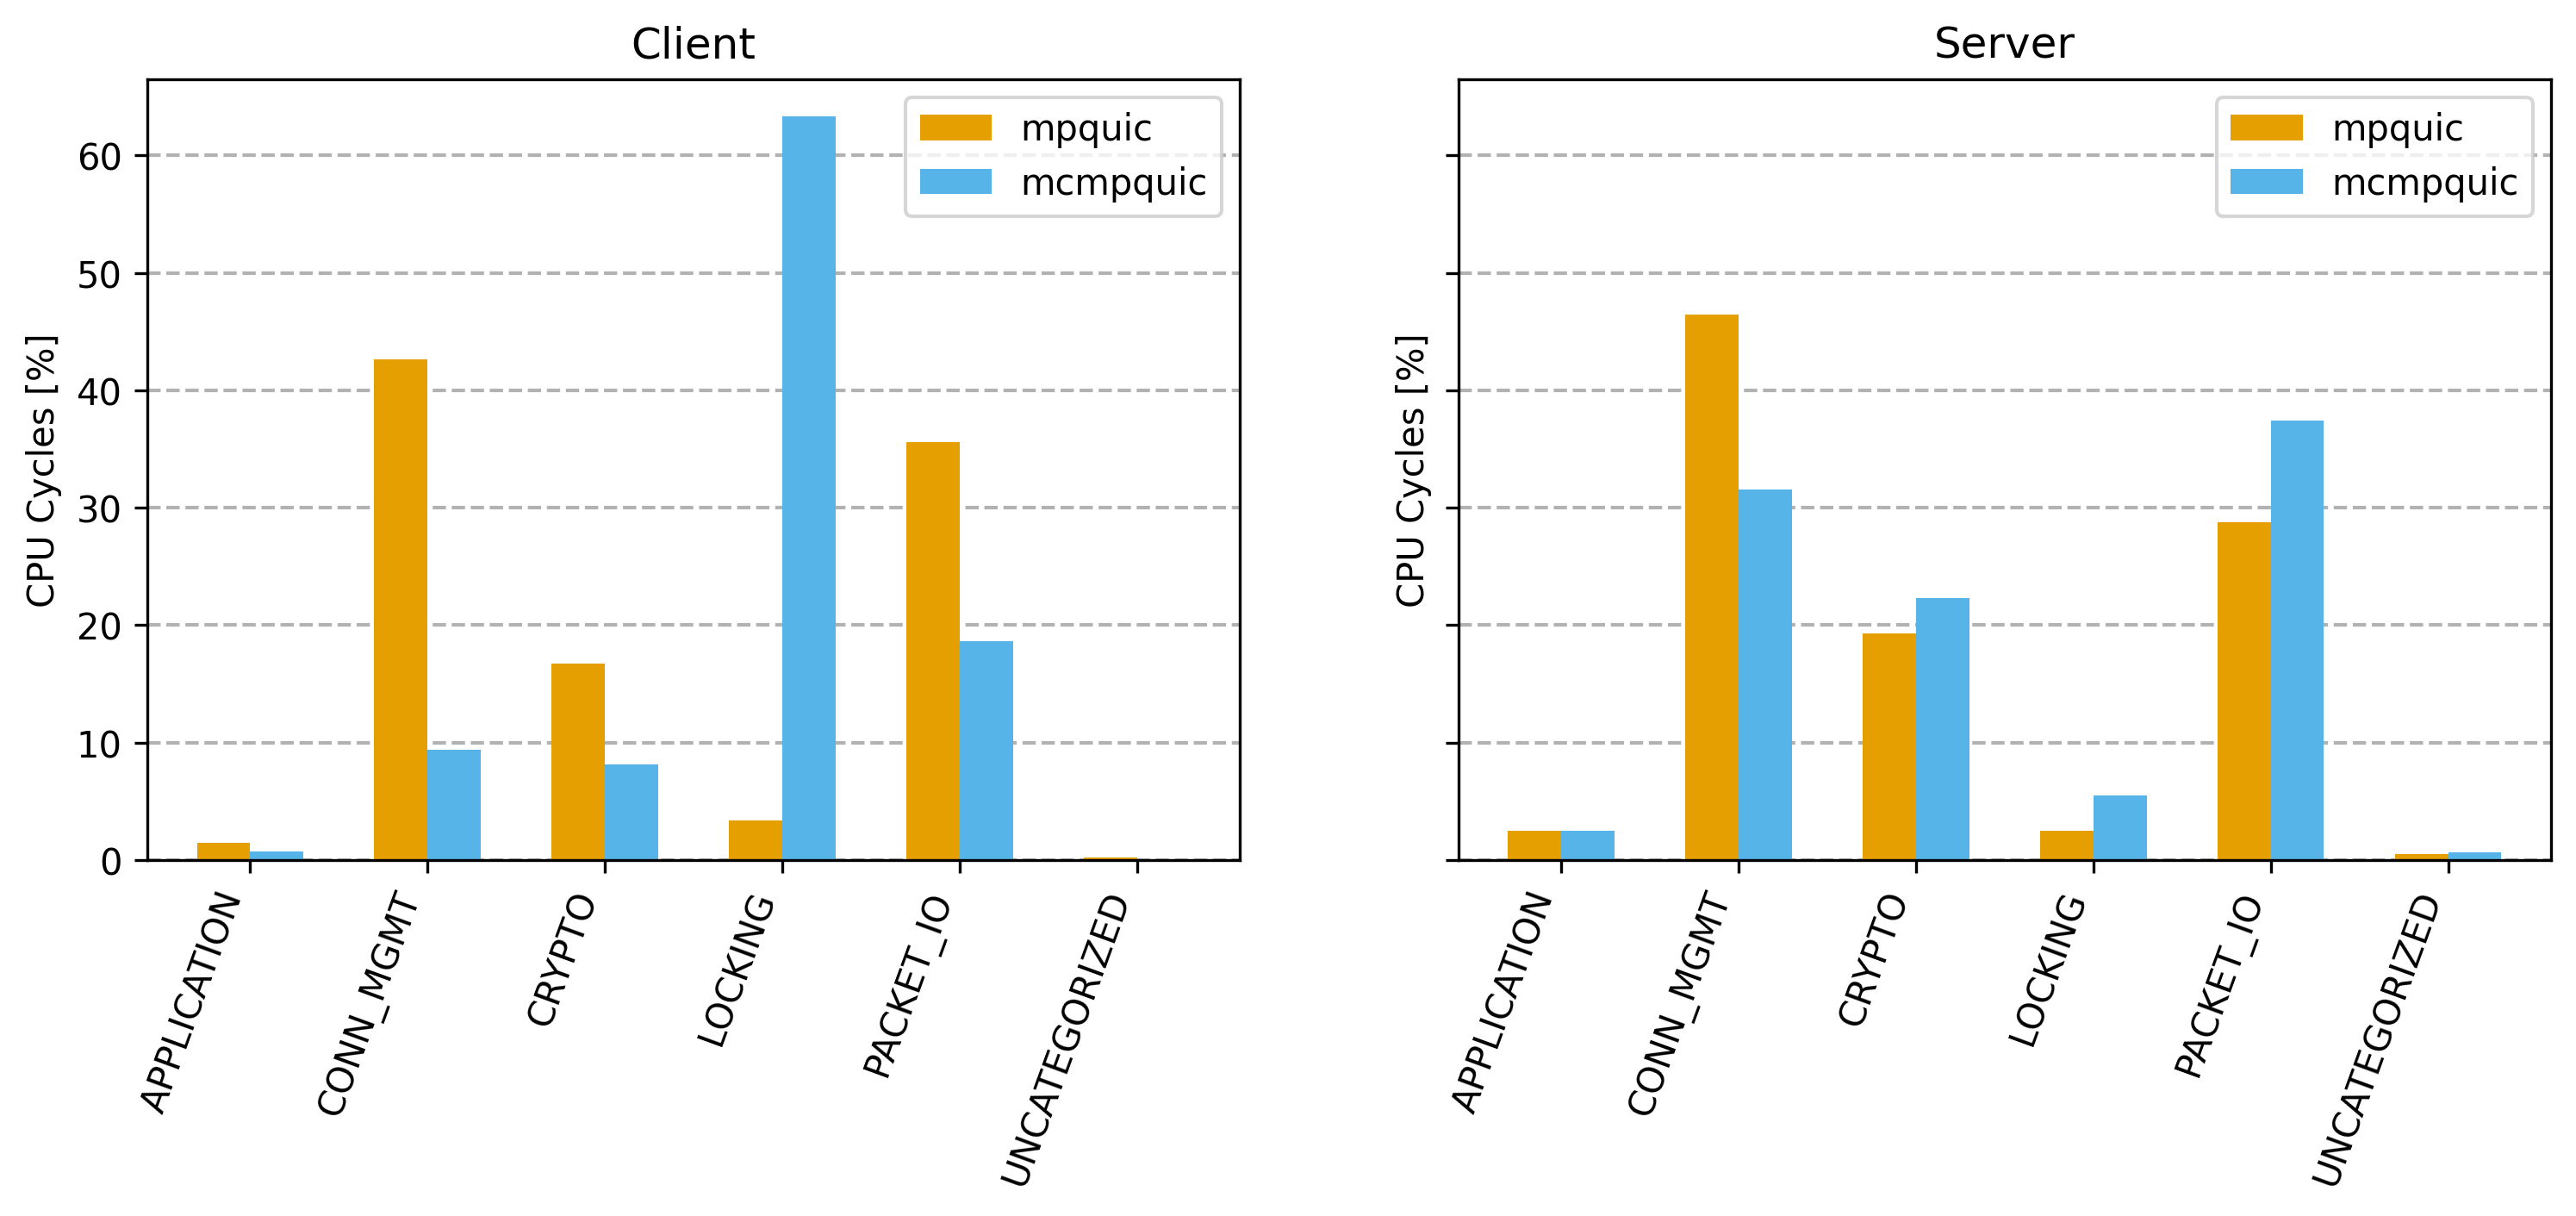

In [21]:
nb_paths = 16
custom_df = df.loc[df["nb_cores"] == nb_paths]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_profiling_per_core(custom_df, "")
plt.savefig(os.path.join(plots_directory, f"profiling_per_core_nb_paths_{nb_paths}.pdf"), bbox_inches='tight', dpi=DPI, format="pdf")

In [22]:
def return_top_k(dictionary, k):
    items = list(dictionary.items())
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    top_k_entries = sorted_items[:k]
    top_k_keys = [entry[0] for entry in top_k_entries]
    top_k_dict = {key: dictionary[key] for key in top_k_keys}
    return top_k_dict

In [24]:
if len(uncategorized) > 0:
    topk = return_top_k(uncategorized, 30)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=DPI)
    ax.bar(topk.keys(), topk.values(), color="#0173B2")
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')